<a href="https://colab.research.google.com/github/ulle9/DL-School/blob/master/NST_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Решите свою задачу

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

# Neural Style Transfer

In [0]:
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary

import copy
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [0]:
# torch.cuda.empty_cache()

In [3]:
# Check GPU availibility and choose device
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = 'cpu'
else:
    print('CUDA is available!  Training on GPU ...')
    device = 'cuda'
    !nvidia-smi

CUDA is available!  Training on GPU ...
Mon Jun  8 12:00:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    59W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                    

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Listing of available content and style files
DIR = Path(r'/content/drive/My Drive/Colab Notebooks/NST/')
for i in DIR.glob('*.*'):
  image = Image.open(i)
  tm = transforms.Compose([transforms.ToTensor()])
  print("{} image size:".format(i.stem), tuple(tm(image).size()))

picasso image size: (3, 1025, 800)
content image size: (3, 882, 614)
vangog image size: (3, 959, 1200)
serov image size: (3, 1350, 1200)
pagoda image size: (3, 681, 1024)


In [0]:
# Formatting images according to our vision/demands
imsize = (681, 1024)

loader = transforms.Compose([
    # transforms.Resize(imsize[1]),
    transforms.CenterCrop(imsize), 
    transforms.ToTensor()])  

# Define file loader function
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(r"/content/drive/My Drive/Colab Notebooks/NST/vangog.jpg")# style photo destination
content_img = image_loader(r"/content/drive/My Drive/Colab Notebooks/NST/pagoda.jpg")# content photo destination

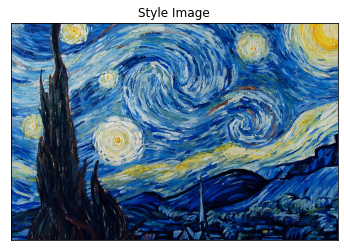

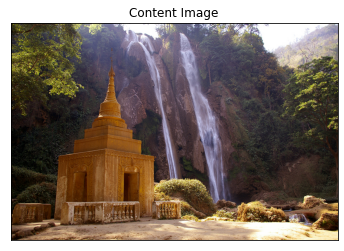

In [7]:
# Drawing function and applying of it
def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0) 
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([]) # remove all labels of axis
    if title is not None:
        plt.title(title)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss function

In [0]:
# Content loss class
class ContentLoss(nn.Module):

        def __init__(self, target):
            super(ContentLoss, self).__init__()

            self.target = target.detach() #remove computational tree
            self.loss = F.mse_loss(self.target, self.target )# to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [0]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1), (h,w)=dimensions of a feature map,  f_map_num=number of feature maps

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix by dividing by the number of elements in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

## Neural Network

In [0]:
# Some experiments with amount of output losses
content_layers_default = ['conv_2']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [34]:
cnn = models.vgg16(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [36]:
summary(cnn, (3, imsize[0], imsize[1]))
print(cnn)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 681, 1024]           1,792
              ReLU-2        [-1, 64, 681, 1024]               0
            Conv2d-3        [-1, 64, 681, 1024]          36,928
              ReLU-4        [-1, 64, 681, 1024]               0
         MaxPool2d-5         [-1, 64, 340, 512]               0
            Conv2d-6        [-1, 128, 340, 512]          73,856
              ReLU-7        [-1, 128, 340, 512]               0
            Conv2d-8        [-1, 128, 340, 512]         147,584
              ReLU-9        [-1, 128, 340, 512]               0
        MaxPool2d-10        [-1, 128, 170, 256]               0
           Conv2d-11        [-1, 256, 170, 256]         295,168
             ReLU-12        [-1, 256, 170, 256]               0
           Conv2d-13        [-1, 256, 170, 256]         590,080
             ReLU-14        [-1, 256, 1

In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, 
                                   content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # making lists in order to have an iterable access to content/syle losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
                print("Pool")
            elif isinstance(layer, nn.BatchNorm2d):
                print("BATCHNORM~~~~~~!!!!!!!!!!!!!")
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего style loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]
        # print(model)
        return model, style_losses, content_losses

In [0]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()], lr=0.1) 
        return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=3000,
                        style_weight=10**6, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:
            # break
            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    # clear_output(wait=True)
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    plt.figure(figsize=(10,15))
                    imshow(input_img.data.clamp_(0, 1), title='Output Image')
                    # plt.ioff(0.1)
                    plt.show()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Building the style transfer model..
Pool
Pool
Pool
Pool
Pool
Optimizing..
run [50]:
Style Loss : 1949.438965 Content Loss: 4.804737


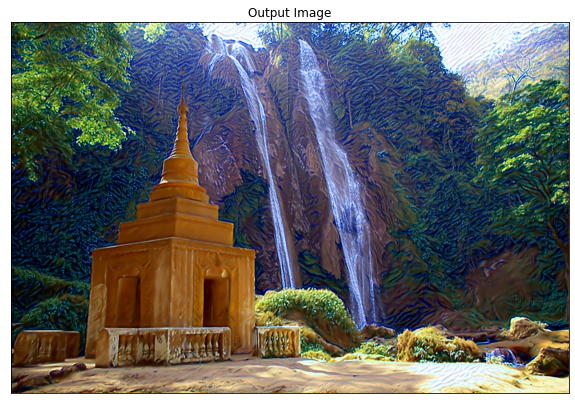

run [100]:
Style Loss : 62.947926 Content Loss: 8.605961


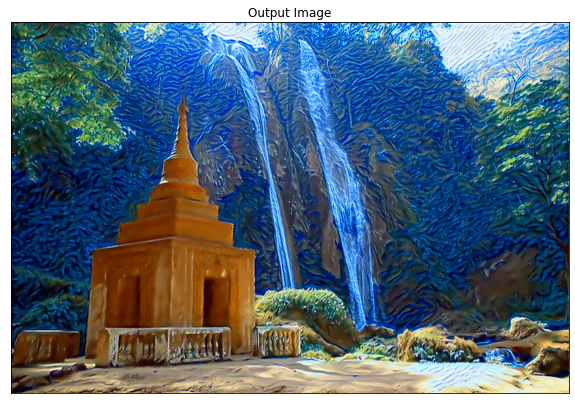

run [150]:
Style Loss : 21.343996 Content Loss: 8.582130


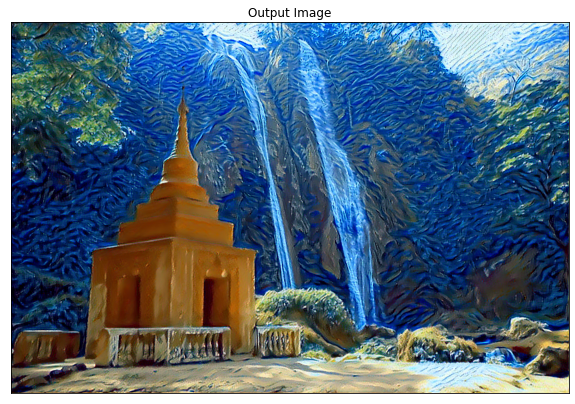

run [200]:
Style Loss : 8.878467 Content Loss: 8.537955


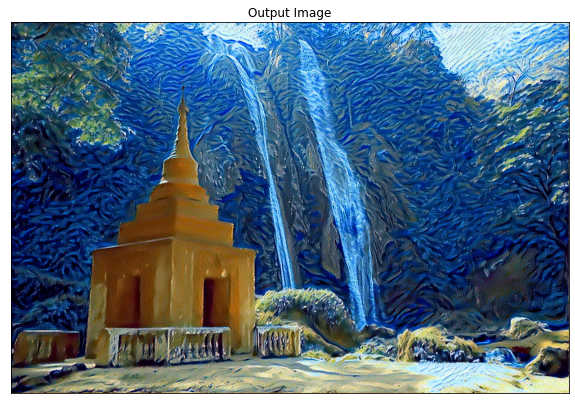

run [250]:
Style Loss : 4.280370 Content Loss: 8.415540


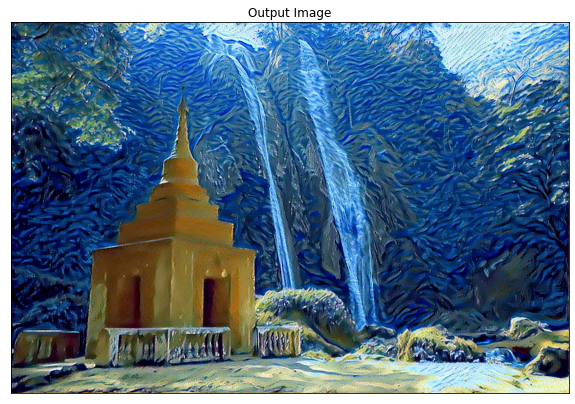

run [300]:
Style Loss : 2.631155 Content Loss: 8.144498


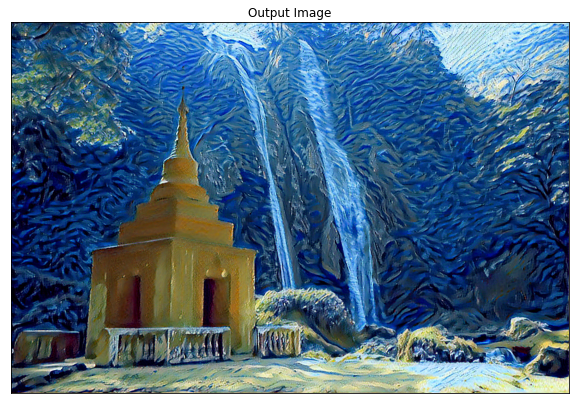

run [350]:
Style Loss : 2.052358 Content Loss: 7.714079


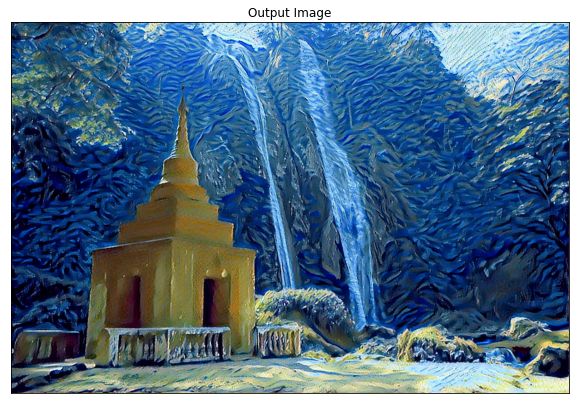

run [400]:
Style Loss : 1.703268 Content Loss: 7.379253


KeyboardInterrupt: ignored

<Figure size 720x1080 with 0 Axes>

In [44]:
input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device) # if you want to use white noise instead uncomment

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)